In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [2]:
train_data_path = "./train.csv"
df_train = pd.read_csv(train_data_path)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data Exploration
### Examine Target Class Distribution

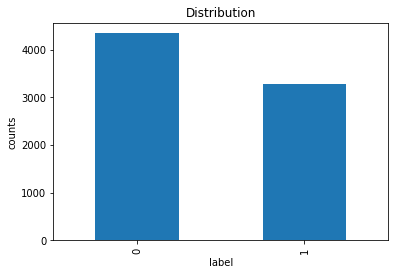

In [4]:
pd.value_counts(df_train['target']).plot.bar()
plt.title('Distribution')
plt.xlabel('label')
plt.ylabel('counts')
plt.show()

The dataset is slightly imbalanced, with more tweets not about real disaster. Hence, data augmentation is performed to generate tweets with label 1.

## Data Splitting

Before data augmentation, data is split into train and test set with ratio 80:20. This is because validation set should not contain augmented data.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(df_train, test_size=0.2)

## Data Augmentation
Data augmentation was done by **synonym replacement**. 
This is done by randomly sample words that are not stop words and replace them with their corresponding synonyms. 
For example, “This exam is pretty hard.” is augmented to “This test is pretty difficult.”

### Word embeddings
To know whether a pair of words are synonyms, GloVe word embeddings are used.

In [9]:
# load glove vectors into dictionary
emb_path = "./glove.6B.100d.txt"

glove_model = {}
with open(emb_path,'r') as f:
    for line in f:
        items = line.split()
        word = items[0]
        emb = np.array(items[1:], dtype=np.float64)
        glove_model[word] = emb.astype('float64')

### Data augmentation on class 1
The synonym replacement was coded manually without packages. From the training data, 300 tweets were sampled to generate augmented data. Each tweet has two words replaced using their synonyms.  

In [14]:
from scipy import spatial

# returns top 5 closest embeddings excluding self
def find_closest_emb(emb):
    return sorted(glove_model.keys(), key=lambda word: spatial.distance.euclidean(glove_model[word], emb))[1:6]

# source dataframe to generate augmentations
df_aug_source = X_train[X_train['target']==1]
df_aug_source.head()

,id,keyword,location,text,target
3237,4649,engulfed,"Fredonia,NY",Just saw a car on the I-77 Fully engulfed in f...,1
1419,2047,casualties,everywhere,Revise the Death to America scenario? \n\nWhil...,1
137,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
4272,6070,heat%20wave,International Action,Heat wave adding to the misery of internally-d...,1
7331,10492,wildfire,Amsterdam | San Francisco,'Some hearths they burn like a wildfire' https...,1


In [15]:
def generate_aug(text):
    words = list(text.split())
    index = list(np.random.randint(0, high=len(words), size=5)) # random index to swap with synonym
    swap = 0
    for i in index:
        if words[i] in glove_model.keys():
            top_5 = find_closest_emb(glove_model[words[i]])
            j = np.random.randint(0, high=5) # randomly choose a synonym from top 5 closest embeddings
            words[i] = top_5[j]
            swap += 1
            if swap == 2:
                break
    text_augment = ' '.join(words)
    return text_augment

def generate_aug_samples(data, num_samples = 300):
    aug_data = []
    index = np.random.randint(0, high=len(data), size=num_samples) # random indexes to generate augmented data from
    for i in index:
        text = data.iloc[i]
        text_augment = generate_aug(text)
        aug_data.append(text_augment)
    return pd.DataFrame(aug_data, columns=['text'])
    
# generate augmented data
df_aug = generate_aug_samples(df_aug_source['text']) 
df_aug.head()

,text
0,BigRigRadio Live Accident Awareness
1,Policyholders object help Clico rescue plan ht...
2,@SoonerMagic_ I means I'm a fan but I don't ne...
3,THE GLOBAL ECONOMIC MELTDOWN is out! http://t....
4,NWS says thunderstorms with deadly lightning w...


In [16]:
df_aug['target'] = 1 # add label to augmented data
df_aug.to_csv('Q6_generated.csv', index=False)

In [17]:
new_df_train = pd.concat([X_train[['text','target']], df_aug])
new_df_train.head()

,text,target
5237,For maximum damage! Activate [BIG BAND MODE] f...,0
1973,HIS MAJESTY EMPEROR SALMAN KHAN'S UNSTOPPABLE ...,0
3237,Just saw a car on the I-77 Fully engulfed in f...,1
2712,Ignition Knock (Detonation) Sensor-Senso Stand...,0
3904,Imagine getting flattened by Kurt Zouma,0


## Tweet Prediction
Train a machine learning model to predict whether a Tweet is about real disasters or not. Two models with the same architecture and hyperparameters are trained on plain data and augmented data respectively.

### Build text embedding

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D, Embedding

In [37]:
# Tokenize train data
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(X_train['text'])

train_tweets = tokenizer.texts_to_sequences(X_train['text'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
val_tweets = tokenizer.texts_to_sequences(X_val['text'].astype(str).values)
val_tweets = pad_sequences(val_tweets, maxlen = max_len)

word_index = tokenizer.word_index
len(word_index)

19384

### Baseline LSTM model (without data augmentation)

In [89]:
## Build model
# model architecture
model = Sequential()
model.add(Embedding(2000, 256, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['AUC'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 29, 256)           512000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 29, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 1,037,826
Trainable params: 1,037,826
Non-trainable params: 0
_________________________________________________________________


In [90]:
tf.config.run_functions_eagerly(True)

# training on plain data
model.fit(train_tweets,
          pd.get_dummies(X_train['target'].values),
          batch_size=512,
          epochs=10)

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
12/12 [==============================] - 1s 65ms/step - loss: 0.6540 - auc: 0.6634
Epoch 2/10
12/12 [==============================] - 1s 61ms/step - loss: 0.5609 - auc: 0.7866
Epoch 3/10
12/12 [==============================] - 1s 59ms/step - loss: 0.4322 - auc: 0.8819
Epoch 4/10
12/12 [==============================] - 1s 59ms/step - loss: 0.3788 - auc: 0.9108
Epoch 5/10
12/12 [==============================] - 1s 62ms/step - loss: 0.3436 - auc: 0.9272
Epoch 6/10
12/12 [==============================] - 1s 63ms/step - loss: 0.3123 - auc: 0.9395
Epoch 7/10
12/12 [==============================] - 1s 62ms/step - loss: 0.2957 - auc: 0.9459
Epoch 8/10
12/12 [==============================] - 1s 61ms/step - loss: 0.2790 - auc: 0.9519
Epoch 9/10
12/12 [==============================] - 1s 61ms/step - loss: 0.2616 - auc: 0.9579
Epoch 10/10
12/12 [==============================] - 1s 60ms/step - loss: 0.2475 - auc: 0.9625


In [91]:
# validation
score, auc = model.evaluate(val_tweets, pd.get_dummies(X_val['target']).values, batch_size = 512)
print("Validation auc: {}".format(auc))

3/3 [==============================] - 0s 27ms/step - loss: 0.5977 - auc: 0.8579
Validation auc: 0.8578559756278992


### LSTM model with augmented data
The same architecture is used for both plain and augmented data. The models were trained with batch size 512 and 10 epochs.

In [92]:
# Tokenize train data
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(new_df_train['text'])

train_tweets = tokenizer.texts_to_sequences(X_train['text'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
val_tweets = tokenizer.texts_to_sequences(X_val['text'].astype(str).values)
val_tweets = pad_sequences(val_tweets, maxlen = max_len)

word_index = tokenizer.word_index
len(word_index)

19451

In [93]:
## Build model

# model architecture
model = Sequential()
model.add(Embedding(2000, 256, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['AUC'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 29, 256)           512000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 29, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 1,037,826
Trainable params: 1,037,826
Non-trainable params: 0
_________________________________________________________________


In [94]:
# training on augmented data
model.fit(train_tweets,
          pd.get_dummies(X_train['target'].values),
          batch_size=512,
          epochs=10)

Epoch 1/10
 2/12 [====>.........................] - ETA: 0s - loss: 0.6878 - auc_1: 0.5738

/anaconda/envs/azureml_py38_tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 [==============================] - 1s 66ms/step - loss: 0.6530 - auc_1: 0.6619
Epoch 2/10
12/12 [==============================] - 1s 59ms/step - loss: 0.5563 - auc_1: 0.7916
Epoch 3/10
12/12 [==============================] - 1s 61ms/step - loss: 0.4313 - auc_1: 0.8819
Epoch 4/10
12/12 [==============================] - 1s 60ms/step - loss: 0.3695 - auc_1: 0.9153
Epoch 5/10
12/12 [==============================] - 1s 60ms/step - loss: 0.3336 - auc_1: 0.9310
Epoch 6/10
12/12 [==============================] - 1s 61ms/step - loss: 0.3072 - auc_1: 0.9415
Epoch 7/10
12/12 [==============================] - 1s 65ms/step - loss: 0.2916 - auc_1: 0.9474
Epoch 8/10
12/12 [==============================] - 1s 62ms/step - loss: 0.2772 - auc_1: 0.9529
Epoch 9/10
12/12 [==============================] - 1s 66ms/step - loss: 0.2641 - auc_1: 0.9572
Epoch 10/10
12/12 [==============================] - 1s 61ms/step - loss: 0.2571 - auc_1: 0.9597


In [95]:
# validation
score, auc = model.evaluate(val_tweets, pd.get_dummies(X_val['target']).values, batch_size = 512)
print("Validation auc: {}".format(auc))

3/3 [==============================] - 0s 27ms/step - loss: 0.5657 - auc_1: 0.8604
Validation auc: 0.8604108691215515


### Conclusion
Data augmentation has improved the performance of the tweet prediction model. With data augmentation, class imbalanced problem can be tackled to improve prediction model performance.